In [1]:
# Yesterday data
yesterday <- read.table("http://azzalini.stat.unipd.it/Book-DM/yesterday.dat", header = TRUE)

In [7]:
attach(yesterday) # make yesterday available without having to reference it

The following objects are masked from yesterday (pos = 3):

    x, y.tomorrow, y.yesterday


The following objects are masked from yesterday (pos = 4):

    x, y.tomorrow, y.yesterday


The following objects are masked from yesterday (pos = 5):

    x, y.tomorrow, y.yesterday




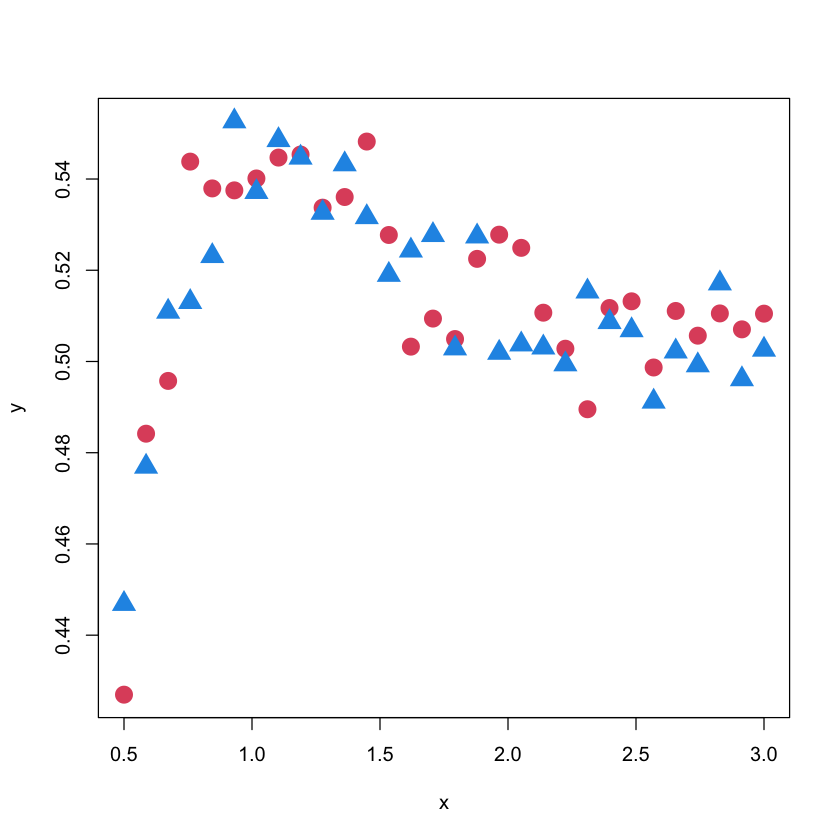

In [8]:
# Plotting the data
y.range <- range(c(y.yesterday, y.tomorrow)) # finding the range
par(bg = "white")
plot(x, y.yesterday, ylim = y.range, col = 2, pch = 16, ylab = "y", cex = 2)
points(x, y.tomorrow, ylim = y.range, col = 4, pch = 17, ylab = "y", cex = 2)


In [9]:
# setting up a function fitting linear models
polynomial <- function(p) lm(y.yesterday ~ poly(x, p))
polynomials <- vector("list", length = 23)
for (p in 1 : 23) {
    polynomials[[p]] <- polynomial(p)
}

In [16]:
polynomials[[1]]$fitted.values

1         2         3         4         5         6         7         8 
0.5191743 0.5189238 0.5186733 0.5184228 0.5181723 0.5179218 0.5176713 0.5174208 
        9        10        11        12        13        14        15        16 
0.5171703 0.5169198 0.5166693 0.5164188 0.5161683 0.5159178 0.5156673 0.5154168 
       17        18        19        20        21        22        23        24 
0.5151663 0.5149158 0.5146652 0.5144147 0.5141642 0.5139137 0.5136632 0.5134127 
       25        26        27        28        29        30 
0.5131622 0.5129117 0.5126612 0.5124107 0.5121602 0.5119097

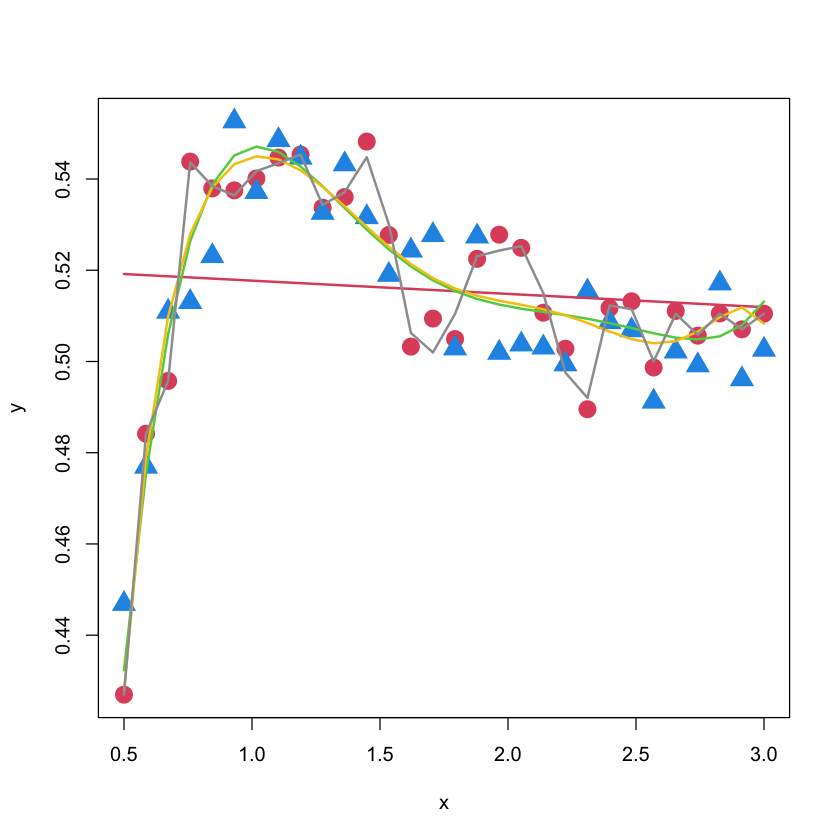

In [19]:
# plotting models for p=1, 5, 8, 23
par(bg = "white")
plot(x, y.yesterday, ylim = y.range, col = 2, pch = 16, ylab = "y", cex = 2)
points(x, y.tomorrow, ylim = y.range, col = 4, pch = 17, ylab = "y", cex = 2)

# plotting the lines
lines(x, polynomials[[1]]$fitted.values, col=2, lwd=2)
lines(x, polynomials[[5]]$fitted.values, col=3, lwd=2)
lines(x, polynomials[[8]]$fitted.values, col=7, lwd=2)
lines(x, polynomials[[23]]$fitted.values, col=8, lwd=2)

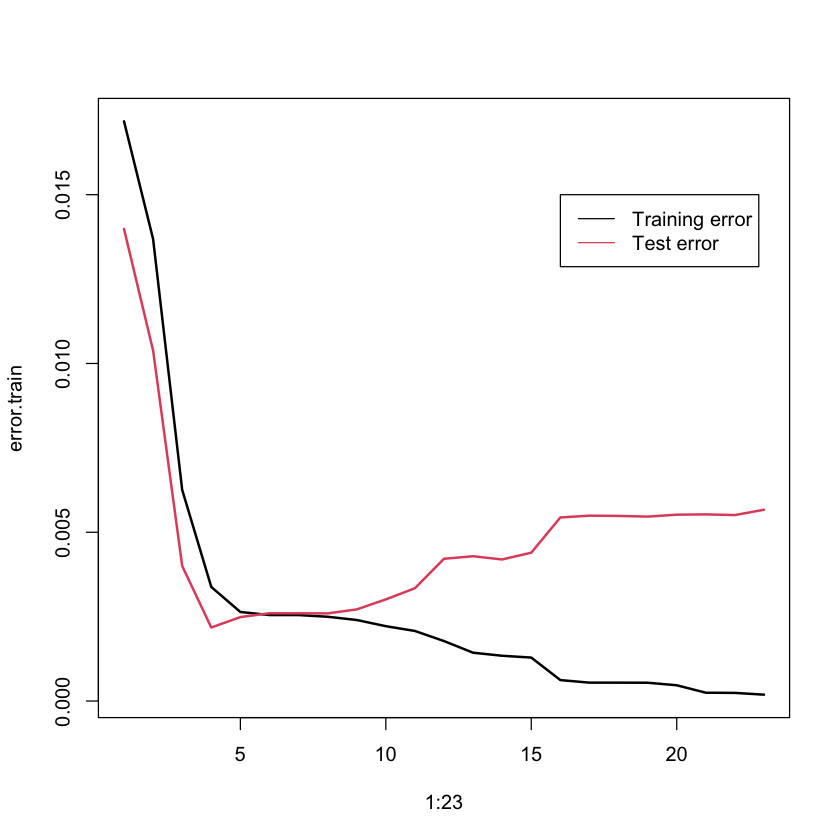

In [28]:
# training and test error
error.train <- error.test <- rep(0, 23)
for(p in 1:23) {
    error.train[p] <- sum((y.yesterday - polynomials[[p]]$fitted.values)^2)
    error.test[p] <- sum((y.tomorrow - polynomials[[p]]$fitted.values)^2)
}

par(bg = "white")
plot(1:23, error.train, type="l", lwd = 2)
lines(1:23, error.test, col = 2, lwd = 2)
legend(16, 0.015, c("Training error", "Test error"), col = 1:2, lty = rep(1, 2))

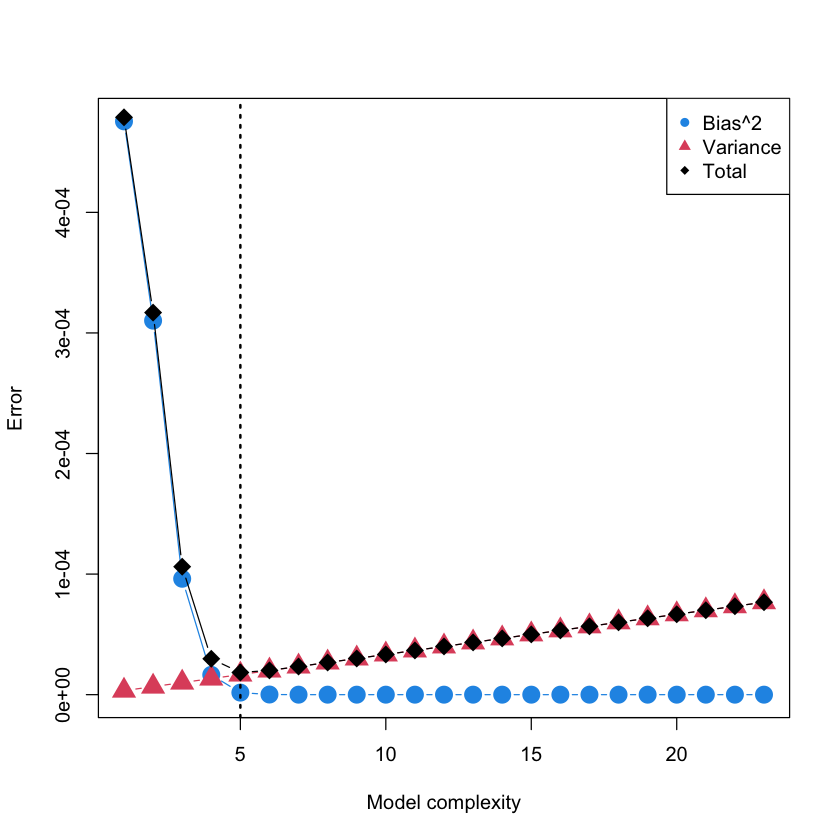

In [38]:
# Computing bias and variance
sigma.eps <- 0.01 # drawn from the info we have on epsilon
N <- length(yesterday[, 1])

source("http://www.uio.no/studier/emner/matnat/math/STK2100/v25/undervisningsmateriell/r-kode/f_true.r") #evaluation of the true f in x
polynomial.true <- function(p) lm(f.true ~ poly(x, p))
polynomials.true <- vector("list", length = 23)
for(p in 1:23) {
    polynomials.true[[p]] <- polynomial.true(p)
}

bias.squared <- variance <- rep(0, 23)
for(p in 1:23) {
    bias.squared[p] <- mean((fitted(polynomials.true[[p]]) - f.true)^2)
    variance[p] <- sigma.eps^2 * p / N
}

err <- bias.squared + variance
min.err <- which.min(err)

par(bg = "white")
plot(bias.squared, type = "b", col = 4, ylab = "Error", xlab = "Model complexity", cex = 2, pch = 16)
lines(variance, type = "b", col = 2, cex = 2, pch = 17)
lines(err, type = "b", cex = 2, pch = 18)
abline(v = min.err, lty = 3, lwd = 2)
legend("topright", legend = c("Bias^2", "Variance", "Total"), col = c(4, 2, 1), pch = c(16, 17, 18))

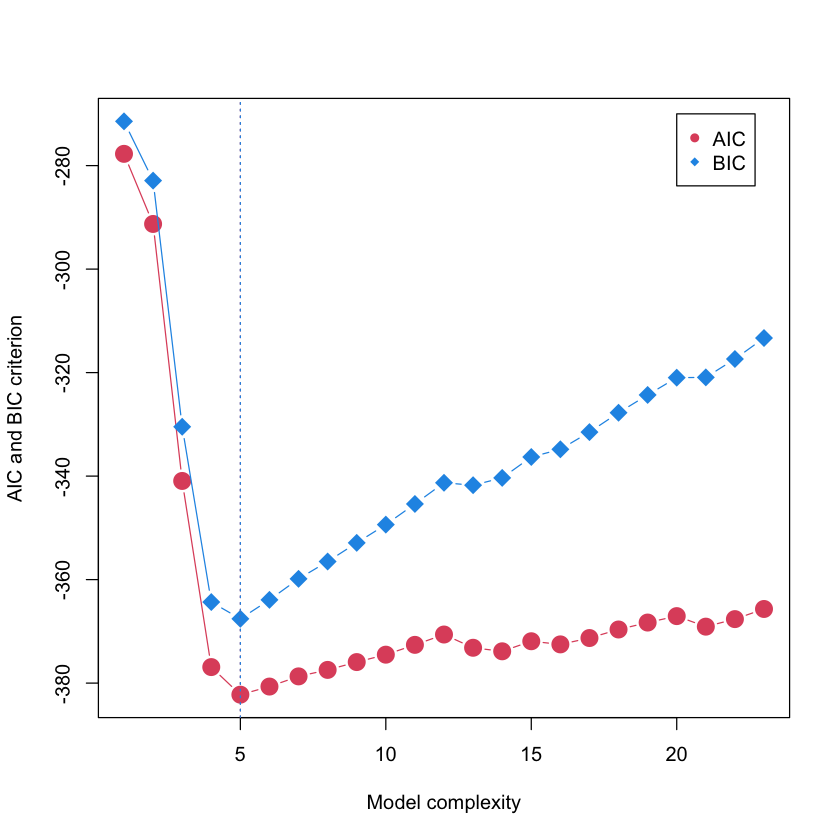

In [47]:
# Information criteria, Akaike and Bayes
# Refitting with all the data

y.all <- c(y.yesterday, y.tomorrow)
x.all <- rep(x, 2)

polynomials.all <- vector("list", length=23)
for (p in 1:23) {
    polynomials.all[[p]] <- lm(y.all ~ poly(x.all, p))
}

AIC.vec <- BIC.vec <- rep(0, 23)
for (p in 1:23) {
    AIC.vec[p] <- AIC(polynomials.all[[p]])
    BIC.vec[p] <- BIC(polynomials.all[[p]])
}

min.AIC <- which.min(AIC.vec)
min.BIC <- which.min(BIC.vec)

par(bg = "white")
plot(1:23, AIC.vec, ylim=c(min(AIC.vec, BIC.vec), max(AIC.vec, BIC.vec)), col = 2, type = "b", pch = 16, cex = 2, xlab = "Model complexity", ylab = "AIC and BIC criterion")
lines(BIC.vec, col = 4, type = "b", pch = 18, cex = 2)
abline(v = min.AIC, lty = 3, col = 2)
abline(v = min.BIC, lty = 3, col = 4)
legend(20, -270, legend = c("AIC", "BIC"), pch = c(16, 18), col = c(2, 4))

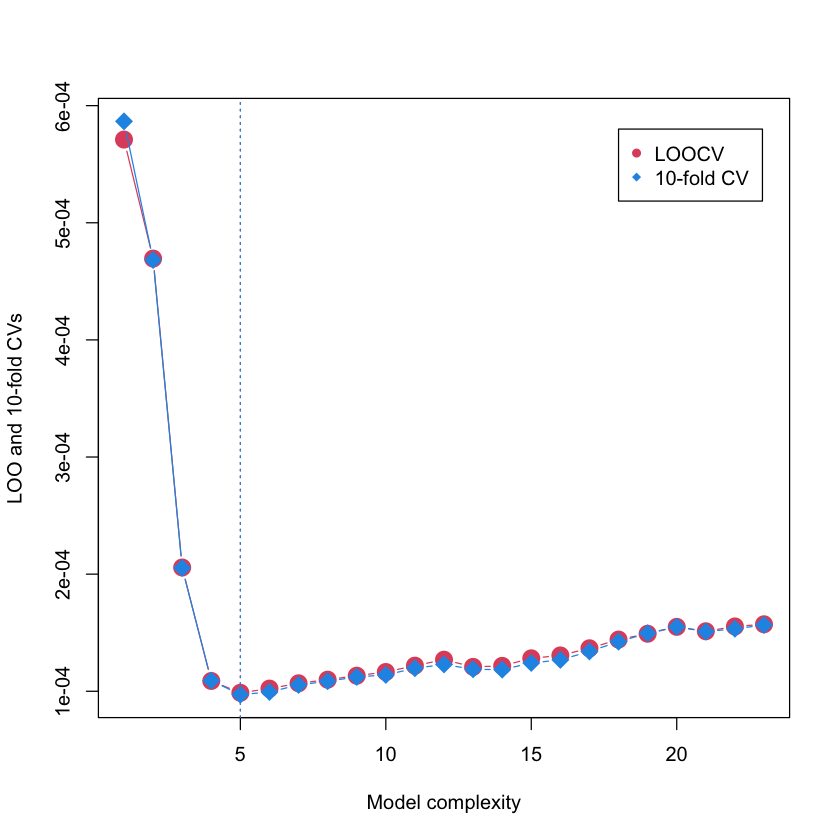

In [54]:
# Cross-validation

# Leave One Out CV - LOOCV
N <- length(y.all)
err.loocv <- rep(0, 23)
for (p in 1:23) {
    for (i in 1:N) {
        polynomials.loocv <- lm(y.all ~ poly(x.all, p), subset = (1:N)[-i])
        err.loocv[p] <- err.loocv[p] + (y.all[i] - predict(polynomials.loocv, data.frame(x.all = x.all[i])))^2 / N
    }
}

# K-fold CV
err.kcv <- rep(0, 23)
set.seed(1977)
K <- 10 # set number of data
index <- sample(rep(1:K, ceiling(N / K))[1:N]) # split data in equi-size fields
for (p in 1:23)
{
    for (k in 1:K) {
        polynomials.kcv <- lm(y.all ~ poly(x.all, p), subset = (1:N)[-which(index == k)])
        for(i in which(index == k)) {
            err.kcv[p] <- err.kcv[p] + (y.all[i] - predict(polynomials.kcv, data.frame(x.all = x.all[i])))^2 / N
        }
    }
}

min.loocv <- which.min(err.loocv)
min.kcv <- which.min(err.kcv)

par(bg = "white")
plot(1:23, err.loocv, ylim = c(min(err.loocv, err.kcv), max(err.loocv, err.kcv)), col = 2, type = "b", pch = 16, cex = 2, xlab = "Model complexity", ylab = "LOO and 10-fold CVs")
lines(1:23, err.kcv, col = 4, type = "b", pch = 18, cex = 2)
abline(v = min.loocv, lty = 3, col = 2)
abline(v = min.kcv, lty = 3, col = 4)
legend(18, 5.8e-04, legend = c("LOOCV","10-fold CV"), pch = c(16,18), col = c(2,4))

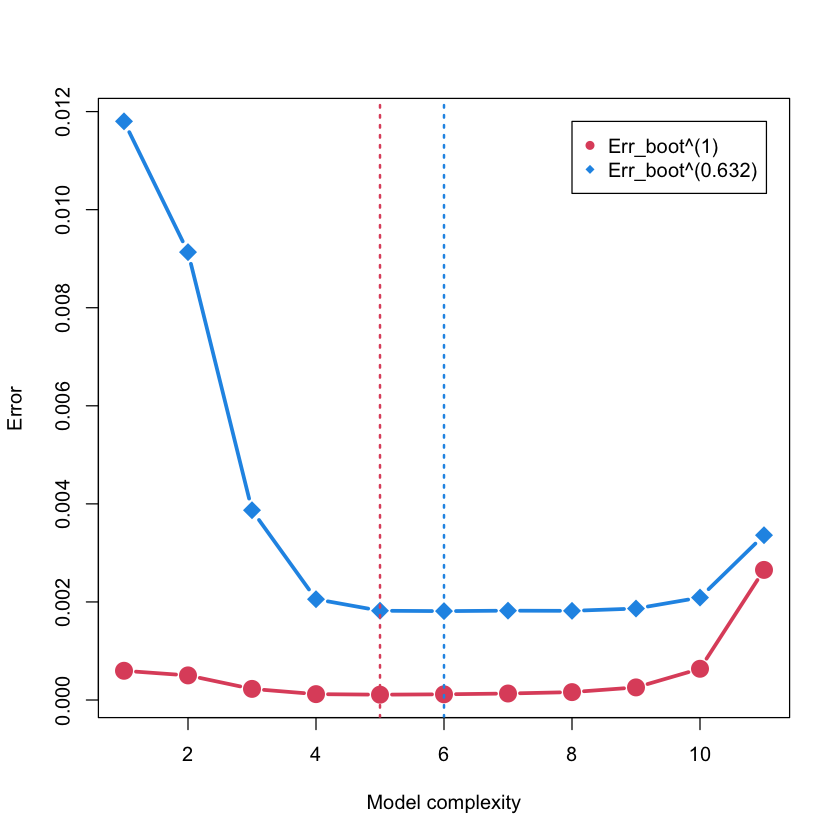

In [63]:
# Bootstrap
B <- 1000
error.train.all <- rep(0, 23)
for (p in 1:23) {
    error.train.all[p] <- sum(polynomials.all[[p]]$residuals^2)
}
err.boot.1 <- rep(0, 11)
n.test <- 0
for (b in 1:B) {
    set.seed(b)
    index <- sample(N, replace = TRUE)
    temp.train.data <- data.frame(y = y.all[index], x = x.all[index]) # selected observations
    temp.test.data <- data.frame(y = y.all[-index], x = x.all[-index]) # rest of the test set
    n.test <- n.test + nrow(temp.test.data)

    for (p in 1:11) {
        polynomials.boot <- lm(y ~ poly(x, p), data = temp.train.data) # fit model on training
        err.boot.1[p] <- err.boot.1[p] + sum((temp.test.data$y-predict(polynomials.boot, newdata = temp.test.data))^2)
    }

}

err.boot.1 <- err.boot.1 / n.test
min.boot.1 <- which.min(err.boot.1)
err.boot.632 <- 0.368 * error.train.all[1:11] + 0.632 * err.boot.1 # 0.632 bootstrap
min.boot.632 <- which.min(err.boot.632)

# plotting
par(bg = "white")
plot(1:11, err.boot.1, ylim = c(min(err.boot.1, err.boot.632), max(err.boot.1, err.boot.632)), type = "b", xlab = "Model complexity", col = 2, pch = 16, ylab = "Error", cex = 2, lwd = 3)
lines(1:11, err.boot.632, type = "b", pch = 18, col = 4, lwd = 3, cex = 2)
abline(v = min.boot.1, lty = 3, col = 2, lwd = 2)
abline(v = min.boot.632, lty = 3, col =4, lwd = 2)
legend(8, 0.0118, c("Err_boot^(1)", "Err_boot^(0.632)"), pch = c(16, 18), col = c(2, 4))
